In [1]:
# Copyright (c) 2024, ETH Zurich

In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import os
import scipy.stats as stats
import scipy.ndimage
from tqdm import tqdm
import spekpy as spk
import h5py

from scipy import interpolate

In [3]:
rave_sim_dir = Path('/mnt/d/rave-sim-main/rave-sim-main')
simulations_dir = Path('/mnt/d/rave-sim-main/rave-sim-main/output')
scratch_dir = simulations_dir

sys.path.insert(0, str(rave_sim_dir / "nist_lookup"))
from nist_lookup.xraydb_plugin import xray_delta_beta

In [4]:
sys.path.insert(0, str(rave_sim_dir / "big-wave"))
import multisim
import config
import util
import propagation


In [5]:
def calculate_G1_height(eng):
    # constants
    h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
    c_0 = 299792458 # speed of light in m / s
    eV_to_joule = 1.602176634*10**(-19)
    N_A = 6.02214086 * 10**23 #[1/mol]
    
    lambda_ = h * c_0 / (eng*eV_to_joule)
    delta_diff = xray_delta_beta('Au', 19.32, eng)[0] -  xray_delta_beta('Si', 2.34, eng)[0]
    height = np.pi  * lambda_ / (2*np.pi * delta_diff)

    return height


def signal_retrieval_least_squares(data, period=None, axis=-1):
    if axis != -1:
        data = np.moveaxis(data, axis, -1)

    nsteps = data.shape[-1]

    if period is None:
        period = nsteps

    phi = np.linspace(0, 2 * np.pi * nsteps / (period), nsteps, endpoint=False)
    M = np.c_[np.sin(phi), np.cos(phi), np.ones(nsteps)]
    res, chi2, _rank, _sing_vals = np.linalg.lstsq(M, data.reshape((-1, nsteps)).T, rcond=-1)

    res = res.T.reshape((*data.shape[:-1], -1))

    dabs = res[...,2]
    dphase = -np.arctan2(res[...,0], res[...,1])
    dvis = np.sqrt(res[...,0]**2 + res[...,1]**2) / dabs

    # normalization to the total number of counts
    dabs *= nsteps

    return dabs, dphase, dvis, np.nanmean(chi2)


def calculate_pixel_intensity(x, fringe, pxEdges, statistics = 'sum'):
    fringeStats = stats.binned_statistic(x, fringe, bins=pxEdges, statistic = statistics)
    return fringeStats.statistic

def perform_binned_signal_retrieval(x, wf, pxSize, nrSteps, plot_curve = True):
    leftSide = np.arange(0-pxSize/2, np.min(x), -pxSize)
    rightSide = np.arange(0 + pxSize/2, np.max(x), pxSize)
    pxEdges = np.concatenate([np.flip(leftSide), rightSide])
    int_px = []
    for i in range(nrSteps):
        int_px.append(calculate_pixel_intensity(x, wf[i,:], pxEdges))
    int_px = np.asarray(int_px)

    trans, phase, vis, _ = signal_retrieval_least_squares(int_px, period = nrSteps, axis = 0)
    if plot_curve:
        plot_curves(trans, phase, vis, pxEdges)
    return int_px, trans, phase, vis, pxEdges

def perform_binning(x, wf, pxSize):
    leftSide = np.arange(0-pxSize/2, np.min(x), -pxSize)
    rightSide = np.arange(0 + pxSize/2, np.max(x), pxSize)
    pxEdges = np.concatenate([np.flip(leftSide), rightSide])
    int_px = calculate_pixel_intensity(x, wf, pxEdges, statistics = 'mean')
    return int_px

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_subdict(dict_, idx):
    sub_dict = {}
    for key in dict_.keys():
        sub_dict[key] = dict_[key][idx]
    return sub_dict

def calc_Vis_theoretical(eng, Edes,m):
    V = 2/np.pi * np.abs(np.sin(np.pi / 2 * Edes / eng)**2 * np.sin(m * np.pi / 2 * Edes / eng))
    return V

In [6]:
# constants
h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
c_0 = 299792458 # speed of light in m / s
eV_to_joule = 1.602176634*10**(-19)
N_A = 6.02214086 * 10**23 #[1/mol]
E_des = 46000

lambda_ = h * c_0 / (E_des*eV_to_joule)
p2 = 4.2*10**(-6)
p0 = p1 = p2

Dn_5 = 5*p2**2/(2*lambda_) / 2

z_g0 = 0.1
z_g1 = z_g0 + Dn_5
z_g2 = z_g0 + 2*Dn_5
z_detector = z_g2 + 0.01

h0 = h2 = 180e-6
h1 = 59e-6

print("Z0: ", z_g0)
print("Z1: ", z_g1)
print("Z2: ", z_g2)
print("Z Detector: ", z_detector)

print(Dn_5)

Z0:  0.1
Z1:  0.9180881351464869
Z2:  1.736176270292974
Z Detector:  1.746176270292974
0.8180881351464869


In [7]:
N = 2**26
max_energy = 70000
dx = propagation.max_dx(z_g0, 200e-6, N, propagation.convert_energy_wavelength(max_energy))

In [8]:
dx**2 / lambda_ * (1 / 0.1)

9.334365630181222e-09

In [9]:
s = spk.Spek(kvp=70, dk = 0.1, th = 10) # Create a spectrum
s.multi_filter((('Be', 0.15), ('Al', 3))) # Create a spectrum
k, f = s.get_spectrum(edges=True) # Get the spectrum

energyRange = [4000, 70000]
dE = 100
filtering = 0.000

energies = np.arange(5, 70+0.1, 0.1)*1e3


tube_spectrum_txt = interpolate.interp1d(k*1e3, f, fill_value = 'extrapolate')
spec_txt = tube_spectrum_txt(energies)

with h5py.File('spectrum_70_spekpy_filtered_3mmAl.h5', 'w') as h5:
    h5.create_dataset('pdf', data =  spec_txt/ np.sum(spec_txt))
    h5.create_dataset('energy', data = energies) 

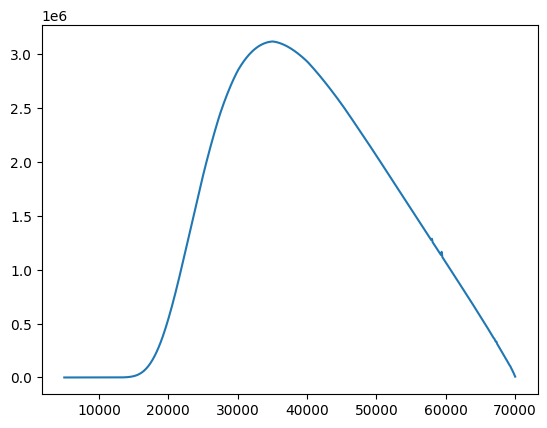

In [10]:
plt.plot(energies, spec_txt)

In [11]:
structure_shift = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

grid_path_g0 = ['/mnt/d/rave-sim-main/rave-sim-main/notebooks/Phase_shift_42_4.npy']
source_sizes = np.array([5, 15, 50, 200])*1e-6

dx_g0 = 1.0151416062788299e-08
dz_g0 = 180e-6 / 20

In [12]:
len(grid_path_g0) * len(source_sizes)

4

In [ ]:
all_sims = []
for grid_path in grid_path_g0:
    for ss in source_sizes:

        config_dict = {
                    "sim_params": {
                        "N": N,
                        "dx": dx,
                        "z_detector": z_g2 + 500e-6,
                        "detector_size": 0.004,
                        "detector_pixel_size_x": 1e-7,
                        "detector_pixel_size_y": 1.0,
                        "chunk_size": 256 * 1024 * 1024 // 16,  # use 256MB chunks
                    },
                    "use_disk_vector": False,
                    "save_final_u_vectors": False,
                    "dtype": "c8",
                    "multisource": {
                        "type": "points",
                        "energy_range": [11000, 70000],
                        "x_range": [-ss.item(), ss.item()],
                        "z": 0.0,
                        "nr_source_points": 10,
                        "seed": 1,
                        "spectrum": '/mnt/d/rave-sim-main/rave-sim-main/notebooks/spectrum_70_spekpy_filtered_3mmAl.h5',
                    },
                    "elements": [
                        {
                            "type": "sample",
                            "z_start": z_g0,
                            "pixel_size_x": dx_g0,
                            "pixel_size_z": dz_g0,
                            "grid_path": '/mnt/d/rave-sim-main/rave-sim-main/notebooks/Phase_shift_42_4.npy',
                            "materials": [["Au", 19.32],["C5H8O2", 1.19]],
                            "x_positions": [0.0],
                        },
                        {
                            "type": "grating",
                            "pitch": 4.2*1e-6,
                            "dc": [1.0, 1.0],
                            "z_start": z_g0 + 180*1e-6,
                            "thickness": 500*1e-6 - h0,
                            "nr_steps": 1,
                            "x_positions": [0.0],
                            "substrate_thickness": 0.0,
                            "mat_a": ["C", 2.26],
                            "mat_b": None,
                            "mat_substrate": None
                        },           
                        {
                            "type": "grating",
                            "pitch": p1,
                            "dc": [0.5, 0.5],
                            "z_start": z_g1,
                            "thickness": h1,
                            "nr_steps": 10,
                            "x_positions": [0.0],
                            "substrate_thickness": 200 * 1e-6 - h1,
                            "mat_a": ["Si", 2.34],
                            "mat_b": None,
                            "mat_substrate": ["Si", 2.34],
                        },
                        {
                            "type": "grating",
                            "pitch": p2,
                            "dc": [0.5, 0.5],
                            "z_start": z_g2,
                            "thickness": h2,
                            "nr_steps": 30,
                            "x_positions": (np.arange(5) * p2/5).tolist(),
                            "substrate_thickness": 500*1e-6 - h2,
                            "mat_a": ["C5H8O2", 1.19],
                            "mat_b": ["Au", 19.32],
                            "mat_substrate": ["C", 2.26],
                        },
                    ],
            }
        sim_path = multisim.setup_simulation(config_dict, Path("."), simulations_dir)

        for i in tqdm(range(config_dict["multisource"]["nr_source_points"])):
            os.system(f"CUDA_VISIBLE_DEVICES=0 /mnt/d/rave-sim-main/rave-sim-main/fast-wave/build-Release/fastwave -s {i} {sim_path}")

        all_sims.append(sim_path)

2025-08-18 10:53:39,122 INFO: Setting up simulation
2025-08-18 10:53:41,048 INFO: Finished setting up simulation in /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241
  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

[2025-08-18 10:53:41.269] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000000
[2025-08-18 10:53:41.704] [info] Simulating optical element 1/4
[2025-08-18 10:53:42.766] [info] Elapsed time for optical element: 1031.7578 ms
[2025-08-18 10:53:42.766] [info] Simulating optical element 2/4
[2025-08-18 10:53:42.798] [info] Elapsed time for optical element: 29.359776 ms
[2025-08-18 10:53:42.823] [info] Simulating optical element 3/4
[2025-08-18 10:53:43.122] [info] Elapsed time for optical element: 275.7223 ms
[2025-08-18 10:53:43.148] [info] Simulating optical element 4/4
[2025-08-18 10:53:43.939] [info] Elapsed time for optical element: 729.7993 ms
[2025-08-18 10:53:43.941] [info] Running phase step 2/5
[2025-08-18 10:53:43.943] [info] Simulating optical element 4/4
[2025-08-18 10:53:44.720] [info] Elapsed time for optical element: 717.20374 ms
[2025-08-18 10:53:44.722] [info] Running phase step 3/5
[2025-08-18 10:53:44.725] [info] Simu

 10%|████████▍                                                                           | 1/10 [00:06<00:54,  6.07s/it]

[2025-08-18 10:53:47.030] [info] Elapsed time for optical element: 697.5991 ms
[2025-08-18 10:53:47.045] [info] Simulation finished in 5.776011179 seconds
[2025-08-18 10:53:47.314] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000001
[2025-08-18 10:53:47.674] [info] Simulating optical element 1/4
[2025-08-18 10:53:48.706] [info] Elapsed time for optical element: 951.955 ms
[2025-08-18 10:53:48.706] [info] Simulating optical element 2/4
[2025-08-18 10:53:48.730] [info] Elapsed time for optical element: 22.413568 ms
[2025-08-18 10:53:48.749] [info] Simulating optical element 3/4
[2025-08-18 10:53:49.014] [info] Elapsed time for optical element: 244.24057 ms
[2025-08-18 10:53:49.036] [info] Simulating optical element 4/4
[2025-08-18 10:53:49.790] [info] Elapsed time for optical element: 695.0858 ms
[2025-08-18 10:53:49.792] [info] Running phase step 2/5
[2025-08-18 10:53:49.794] [info] Simulating optical element 4/4
[2025-08-18 10:53:5

 20%|████████████████▊                                                                   | 2/10 [00:11<00:47,  5.90s/it]

[2025-08-18 10:53:52.809] [info] Elapsed time for optical element: 692.7684 ms
[2025-08-18 10:53:52.824] [info] Simulation finished in 5.510204372 seconds
[2025-08-18 10:53:53.090] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000002
[2025-08-18 10:53:53.438] [info] Simulating optical element 1/4
[2025-08-18 10:53:54.406] [info] Elapsed time for optical element: 892.96265 ms
[2025-08-18 10:53:54.406] [info] Simulating optical element 2/4
[2025-08-18 10:53:54.430] [info] Elapsed time for optical element: 22.241823 ms
[2025-08-18 10:53:54.449] [info] Simulating optical element 3/4
[2025-08-18 10:53:54.709] [info] Elapsed time for optical element: 239.37686 ms
[2025-08-18 10:53:54.730] [info] Simulating optical element 4/4
[2025-08-18 10:53:55.469] [info] Elapsed time for optical element: 681.56354 ms
[2025-08-18 10:53:55.471] [info] Running phase step 2/5
[2025-08-18 10:53:55.473] [info] Simulating optical element 4/4
[2025-08-18 10:5

 30%|█████████████████████████▏                                                          | 3/10 [00:16<00:37,  5.30s/it]

[2025-08-18 10:53:57.388] [info] Elapsed time for optical element: 700.11786 ms
[2025-08-18 10:53:57.403] [info] Simulation finished in 5.436852005 seconds
[2025-08-18 10:53:57.664] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000003
[2025-08-18 10:53:58.016] [info] Simulating optical element 1/4
[2025-08-18 10:53:59.017] [info] Elapsed time for optical element: 924.0597 ms
[2025-08-18 10:53:59.017] [info] Simulating optical element 2/4
[2025-08-18 10:53:59.042] [info] Elapsed time for optical element: 22.386305 ms
[2025-08-18 10:53:59.061] [info] Simulating optical element 3/4
[2025-08-18 10:53:59.323] [info] Elapsed time for optical element: 241.67773 ms
[2025-08-18 10:53:59.345] [info] Simulating optical element 4/4
[2025-08-18 10:54:00.145] [info] Elapsed time for optical element: 738.5755 ms
[2025-08-18 10:54:00.147] [info] Running phase step 2/5
[2025-08-18 10:54:00.149] [info] Simulating optical element 4/4
[2025-08-18 10:54

 40%|█████████████████████████████████▌                                                  | 4/10 [00:22<00:32,  5.48s/it]

[2025-08-18 10:54:03.142] [info] Elapsed time for optical element: 686.89667 ms
[2025-08-18 10:54:03.158] [info] Simulation finished in 5.493328789 seconds
[2025-08-18 10:54:03.448] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000004
[2025-08-18 10:54:03.820] [info] Simulating optical element 1/4
[2025-08-18 10:54:04.835] [info] Elapsed time for optical element: 936.8561 ms
[2025-08-18 10:54:04.835] [info] Simulating optical element 2/4
[2025-08-18 10:54:04.860] [info] Elapsed time for optical element: 22.407648 ms
[2025-08-18 10:54:04.879] [info] Simulating optical element 3/4
[2025-08-18 10:54:05.140] [info] Elapsed time for optical element: 240.86519 ms
[2025-08-18 10:54:05.162] [info] Simulating optical element 4/4
[2025-08-18 10:54:05.908] [info] Elapsed time for optical element: 688.1251 ms
[2025-08-18 10:54:05.910] [info] Running phase step 2/5
[2025-08-18 10:54:05.912] [info] Simulating optical element 4/4
[2025-08-18 10:54

 50%|██████████████████████████████████████████                                          | 5/10 [00:27<00:27,  5.58s/it]

[2025-08-18 10:54:08.895] [info] Elapsed time for optical element: 684.50323 ms
[2025-08-18 10:54:08.908] [info] Simulation finished in 5.459265038 seconds
[2025-08-18 10:54:09.172] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000005
[2025-08-18 10:54:09.508] [info] Simulating optical element 1/4
[2025-08-18 10:54:10.477] [info] Elapsed time for optical element: 894.87805 ms
[2025-08-18 10:54:10.477] [info] Simulating optical element 2/4
[2025-08-18 10:54:10.502] [info] Elapsed time for optical element: 22.2016 ms
[2025-08-18 10:54:10.521] [info] Simulating optical element 3/4
[2025-08-18 10:54:10.782] [info] Elapsed time for optical element: 240.96298 ms
[2025-08-18 10:54:10.804] [info] Simulating optical element 4/4
[2025-08-18 10:54:11.549] [info] Elapsed time for optical element: 687.80804 ms
[2025-08-18 10:54:11.552] [info] Running phase step 2/5
[2025-08-18 10:54:11.554] [info] Simulating optical element 4/4
[2025-08-18 10:54

 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:33<00:22,  5.60s/it]

[2025-08-18 10:54:14.533] [info] Elapsed time for optical element: 683.5619 ms
[2025-08-18 10:54:14.546] [info] Simulation finished in 5.373863113 seconds
[2025-08-18 10:54:14.807] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000006
[2025-08-18 10:54:15.131] [info] Simulating optical element 1/4
[2025-08-18 10:54:16.101] [info] Elapsed time for optical element: 895.42236 ms
[2025-08-18 10:54:16.101] [info] Simulating optical element 2/4
[2025-08-18 10:54:16.125] [info] Elapsed time for optical element: 22.337343 ms
[2025-08-18 10:54:16.145] [info] Simulating optical element 3/4
[2025-08-18 10:54:16.406] [info] Elapsed time for optical element: 241.30925 ms
[2025-08-18 10:54:16.428] [info] Simulating optical element 4/4
[2025-08-18 10:54:17.172] [info] Elapsed time for optical element: 690.1274 ms
[2025-08-18 10:54:17.174] [info] Running phase step 2/5
[2025-08-18 10:54:17.176] [info] Simulating optical element 4/4
[2025-08-18 10:54

 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [00:39<00:16,  5.60s/it]

[2025-08-18 10:54:20.130] [info] Elapsed time for optical element: 686.3712 ms
[2025-08-18 10:54:20.142] [info] Simulation finished in 5.334435251 seconds
[2025-08-18 10:54:20.399] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000007
[2025-08-18 10:54:20.722] [info] Simulating optical element 1/4
[2025-08-18 10:54:21.680] [info] Elapsed time for optical element: 895.39124 ms
[2025-08-18 10:54:21.680] [info] Simulating optical element 2/4
[2025-08-18 10:54:21.704] [info] Elapsed time for optical element: 22.316511 ms
[2025-08-18 10:54:21.723] [info] Simulating optical element 3/4
[2025-08-18 10:54:21.983] [info] Elapsed time for optical element: 242.36899 ms
[2025-08-18 10:54:22.004] [info] Simulating optical element 4/4
[2025-08-18 10:54:22.746] [info] Elapsed time for optical element: 692.7462 ms
[2025-08-18 10:54:22.748] [info] Running phase step 2/5
[2025-08-18 10:54:22.750] [info] Simulating optical element 4/4
[2025-08-18 10:54

 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [00:44<00:11,  5.59s/it]

[2025-08-18 10:54:25.702] [info] Elapsed time for optical element: 688.28357 ms
[2025-08-18 10:54:25.717] [info] Simulation finished in 5.318157657 seconds
[2025-08-18 10:54:25.962] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000008
[2025-08-18 10:54:26.283] [info] Simulating optical element 1/4
[2025-08-18 10:54:27.207] [info] Elapsed time for optical element: 895.6347 ms
[2025-08-18 10:54:27.207] [info] Simulating optical element 2/4
[2025-08-18 10:54:27.230] [info] Elapsed time for optical element: 22.370049 ms
[2025-08-18 10:54:27.249] [info] Simulating optical element 3/4
[2025-08-18 10:54:27.499] [info] Elapsed time for optical element: 242.32614 ms
[2025-08-18 10:54:27.520] [info] Simulating optical element 4/4
[2025-08-18 10:54:28.236] [info] Elapsed time for optical element: 694.67175 ms
[2025-08-18 10:54:28.239] [info] Running phase step 2/5
[2025-08-18 10:54:28.241] [info] Simulating optical element 4/4
[2025-08-18 10:5

 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [00:47<00:04,  4.82s/it]

[2025-08-18 10:54:28.828] [info] Elapsed time for optical element: 689.23193 ms
[2025-08-18 10:54:28.840] [info] Simulation finished in 5.151029901 seconds
[2025-08-18 10:54:29.091] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105340602241/00000009
[2025-08-18 10:54:29.415] [info] Simulating optical element 1/4
[2025-08-18 10:54:30.340] [info] Elapsed time for optical element: 897.2842 ms
[2025-08-18 10:54:30.340] [info] Simulating optical element 2/4
[2025-08-18 10:54:30.363] [info] Elapsed time for optical element: 22.489376 ms
[2025-08-18 10:54:30.382] [info] Simulating optical element 3/4
[2025-08-18 10:54:30.632] [info] Elapsed time for optical element: 242.71837 ms
[2025-08-18 10:54:30.653] [info] Simulating optical element 4/4
[2025-08-18 10:54:31.371] [info] Elapsed time for optical element: 695.90155 ms
[2025-08-18 10:54:31.373] [info] Running phase step 2/5
[2025-08-18 10:54:31.375] [info] Simulating optical element 4/4
[2025-08-18 10:5

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.33s/it]
2025-08-18 10:54:34,335 INFO: Setting up simulation


[2025-08-18 10:54:34.242] [info] Elapsed time for optical element: 691.5073 ms
[2025-08-18 10:54:34.256] [info] Simulation finished in 5.164545967 seconds


2025-08-18 10:54:36,184 INFO: Finished setting up simulation in /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785
  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

[2025-08-18 10:54:36.372] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000000
[2025-08-18 10:54:36.739] [info] Simulating optical element 1/4
[2025-08-18 10:54:37.707] [info] Elapsed time for optical element: 942.3261 ms
[2025-08-18 10:54:37.707] [info] Simulating optical element 2/4
[2025-08-18 10:54:37.730] [info] Elapsed time for optical element: 22.329184 ms
[2025-08-18 10:54:37.749] [info] Simulating optical element 3/4
[2025-08-18 10:54:37.998] [info] Elapsed time for optical element: 242.48355 ms
[2025-08-18 10:54:38.019] [info] Simulating optical element 4/4
[2025-08-18 10:54:38.733] [info] Elapsed time for optical element: 694.5805 ms
[2025-08-18 10:54:38.735] [info] Running phase step 2/5
[2025-08-18 10:54:38.737] [info] Simulating optical element 4/4
[2025-08-18 10:54:39.444] [info] Elapsed time for optical element: 688.14087 ms
[2025-08-18 10:54:39.446] [info] Running phase step 3/5
[2025-08-18 10:54:39.448] [info] Simu

 10%|████████▍                                                                           | 1/10 [00:05<00:49,  5.50s/it]

[2025-08-18 10:54:41.588] [info] Elapsed time for optical element: 689.5967 ms
[2025-08-18 10:54:41.600] [info] Simulation finished in 5.228147039 seconds
[2025-08-18 10:54:41.862] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000001
[2025-08-18 10:54:42.212] [info] Simulating optical element 1/4
[2025-08-18 10:54:43.183] [info] Elapsed time for optical element: 895.7222 ms
[2025-08-18 10:54:43.183] [info] Simulating optical element 2/4
[2025-08-18 10:54:43.207] [info] Elapsed time for optical element: 22.263647 ms
[2025-08-18 10:54:43.226] [info] Simulating optical element 3/4
[2025-08-18 10:54:43.491] [info] Elapsed time for optical element: 243.99133 ms
[2025-08-18 10:54:43.513] [info] Simulating optical element 4/4
[2025-08-18 10:54:44.270] [info] Elapsed time for optical element: 698.53516 ms
[2025-08-18 10:54:44.272] [info] Running phase step 2/5
[2025-08-18 10:54:44.274] [info] Simulating optical element 4/4
[2025-08-18 10:54

 20%|████████████████▊                                                                   | 2/10 [00:11<00:44,  5.62s/it]

[2025-08-18 10:54:47.302] [info] Elapsed time for optical element: 695.11816 ms
[2025-08-18 10:54:47.315] [info] Simulation finished in 5.452683546 seconds
[2025-08-18 10:54:47.580] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000002
[2025-08-18 10:54:47.924] [info] Simulating optical element 1/4
[2025-08-18 10:54:48.936] [info] Elapsed time for optical element: 934.39996 ms
[2025-08-18 10:54:48.936] [info] Simulating optical element 2/4
[2025-08-18 10:54:48.961] [info] Elapsed time for optical element: 22.249472 ms
[2025-08-18 10:54:48.980] [info] Simulating optical element 3/4
[2025-08-18 10:54:49.239] [info] Elapsed time for optical element: 239.60349 ms
[2025-08-18 10:54:49.261] [info] Simulating optical element 4/4
[2025-08-18 10:54:50.004] [info] Elapsed time for optical element: 685.3846 ms
[2025-08-18 10:54:50.006] [info] Running phase step 2/5
[2025-08-18 10:54:50.009] [info] Simulating optical element 4/4
[2025-08-18 10:5

 30%|█████████████████████████▏                                                          | 3/10 [00:16<00:39,  5.65s/it]

[2025-08-18 10:54:52.975] [info] Elapsed time for optical element: 680.04395 ms
[2025-08-18 10:54:52.987] [info] Simulation finished in 5.407162065 seconds
[2025-08-18 10:54:53.244] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000003
[2025-08-18 10:54:53.582] [info] Simulating optical element 1/4
[2025-08-18 10:54:54.553] [info] Elapsed time for optical element: 896.3303 ms
[2025-08-18 10:54:54.553] [info] Simulating optical element 2/4
[2025-08-18 10:54:54.577] [info] Elapsed time for optical element: 22.332865 ms
[2025-08-18 10:54:54.597] [info] Simulating optical element 3/4
[2025-08-18 10:54:54.859] [info] Elapsed time for optical element: 242.12602 ms
[2025-08-18 10:54:54.881] [info] Simulating optical element 4/4
[2025-08-18 10:54:55.633] [info] Elapsed time for optical element: 693.5522 ms
[2025-08-18 10:54:55.635] [info] Running phase step 2/5
[2025-08-18 10:54:55.637] [info] Simulating optical element 4/4
[2025-08-18 10:54

 40%|█████████████████████████████████▌                                                  | 4/10 [00:22<00:33,  5.65s/it]

[2025-08-18 10:54:58.639] [info] Elapsed time for optical element: 688.83685 ms
[2025-08-18 10:54:58.654] [info] Simulation finished in 5.409834162 seconds
[2025-08-18 10:54:57.179] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000004
[2025-08-18 10:54:57.533] [info] Simulating optical element 1/4
[2025-08-18 10:54:58.505] [info] Elapsed time for optical element: 897.235 ms
[2025-08-18 10:54:58.505] [info] Simulating optical element 2/4
[2025-08-18 10:54:58.529] [info] Elapsed time for optical element: 22.348864 ms
[2025-08-18 10:54:58.549] [info] Simulating optical element 3/4
[2025-08-18 10:54:58.810] [info] Elapsed time for optical element: 241.23843 ms
[2025-08-18 10:54:58.832] [info] Simulating optical element 4/4
[2025-08-18 10:54:59.582] [info] Elapsed time for optical element: 692.2851 ms
[2025-08-18 10:54:59.584] [info] Running phase step 2/5
[2025-08-18 10:54:59.586] [info] Simulating optical element 4/4
[2025-08-18 10:55:

 50%|██████████████████████████████████████████                                          | 5/10 [00:26<00:25,  5.04s/it]

[2025-08-18 10:55:02.580] [info] Elapsed time for optical element: 687.72565 ms
[2025-08-18 10:55:02.594] [info] Simulation finished in 5.415647041 seconds
[2025-08-18 10:55:02.857] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000005
[2025-08-18 10:55:03.207] [info] Simulating optical element 1/4
[2025-08-18 10:55:04.176] [info] Elapsed time for optical element: 894.704 ms
[2025-08-18 10:55:04.176] [info] Simulating optical element 2/4
[2025-08-18 10:55:04.200] [info] Elapsed time for optical element: 22.2984 ms
[2025-08-18 10:55:04.220] [info] Simulating optical element 3/4
[2025-08-18 10:55:04.481] [info] Elapsed time for optical element: 240.77866 ms
[2025-08-18 10:55:04.503] [info] Simulating optical element 4/4
[2025-08-18 10:55:05.251] [info] Elapsed time for optical element: 691.16534 ms
[2025-08-18 10:55:05.254] [info] Running phase step 2/5
[2025-08-18 10:55:05.256] [info] Simulating optical element 4/4
[2025-08-18 10:55:0

 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:32<00:21,  5.25s/it]

[2025-08-18 10:55:08.244] [info] Elapsed time for optical element: 685.25214 ms
[2025-08-18 10:55:08.257] [info] Simulation finished in 5.400130753 seconds
[2025-08-18 10:55:08.525] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000006
[2025-08-18 10:55:08.864] [info] Simulating optical element 1/4
[2025-08-18 10:55:09.833] [info] Elapsed time for optical element: 894.6551 ms
[2025-08-18 10:55:09.833] [info] Simulating optical element 2/4
[2025-08-18 10:55:09.857] [info] Elapsed time for optical element: 22.344992 ms
[2025-08-18 10:55:09.876] [info] Simulating optical element 3/4
[2025-08-18 10:55:10.138] [info] Elapsed time for optical element: 241.45299 ms
[2025-08-18 10:55:10.160] [info] Simulating optical element 4/4
[2025-08-18 10:55:10.911] [info] Elapsed time for optical element: 692.55566 ms
[2025-08-18 10:55:10.913] [info] Running phase step 2/5
[2025-08-18 10:55:10.915] [info] Simulating optical element 4/4
[2025-08-18 10:5

 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [00:37<00:16,  5.39s/it]

[2025-08-18 10:55:13.911] [info] Elapsed time for optical element: 687.7673 ms
[2025-08-18 10:55:13.925] [info] Simulation finished in 5.40083155 seconds
[2025-08-18 10:55:14.189] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000007
[2025-08-18 10:55:14.547] [info] Simulating optical element 1/4
[2025-08-18 10:55:15.540] [info] Elapsed time for optical element: 916.3327 ms
[2025-08-18 10:55:15.540] [info] Simulating optical element 2/4
[2025-08-18 10:55:15.568] [info] Elapsed time for optical element: 26.102432 ms
[2025-08-18 10:55:15.591] [info] Simulating optical element 3/4
[2025-08-18 10:55:15.871] [info] Elapsed time for optical element: 258.66638 ms
[2025-08-18 10:55:15.897] [info] Simulating optical element 4/4
[2025-08-18 10:55:16.706] [info] Elapsed time for optical element: 747.2795 ms
[2025-08-18 10:55:16.709] [info] Running phase step 2/5
[2025-08-18 10:55:16.712] [info] Simulating optical element 4/4
[2025-08-18 10:55:1

 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [00:43<00:11,  5.53s/it]

[2025-08-18 10:55:19.752] [info] Elapsed time for optical element: 689.9648 ms
[2025-08-18 10:55:19.768] [info] Simulation finished in 5.57841856 seconds
[2025-08-18 10:55:20.034] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000008
[2025-08-18 10:55:20.390] [info] Simulating optical element 1/4
[2025-08-18 10:55:21.363] [info] Elapsed time for optical element: 897.6674 ms
[2025-08-18 10:55:21.363] [info] Simulating optical element 2/4
[2025-08-18 10:55:21.387] [info] Elapsed time for optical element: 22.309696 ms
[2025-08-18 10:55:21.407] [info] Simulating optical element 3/4
[2025-08-18 10:55:21.669] [info] Elapsed time for optical element: 242.42604 ms
[2025-08-18 10:55:21.691] [info] Simulating optical element 4/4
[2025-08-18 10:55:22.446] [info] Elapsed time for optical element: 696.03705 ms
[2025-08-18 10:55:22.448] [info] Running phase step 2/5
[2025-08-18 10:55:22.450] [info] Simulating optical element 4/4
[2025-08-18 10:55:

 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [00:49<00:05,  5.59s/it]

[2025-08-18 10:55:25.461] [info] Elapsed time for optical element: 690.5988 ms
[2025-08-18 10:55:25.477] [info] Simulation finished in 5.442961474 seconds
[2025-08-18 10:55:25.739] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105435728785/00000009
[2025-08-18 10:55:26.080] [info] Simulating optical element 1/4
[2025-08-18 10:55:27.053] [info] Elapsed time for optical element: 897.9453 ms
[2025-08-18 10:55:27.053] [info] Simulating optical element 2/4
[2025-08-18 10:55:27.077] [info] Elapsed time for optical element: 22.393568 ms
[2025-08-18 10:55:27.097] [info] Simulating optical element 3/4
[2025-08-18 10:55:27.360] [info] Elapsed time for optical element: 242.97389 ms
[2025-08-18 10:55:27.382] [info] Simulating optical element 4/4
[2025-08-18 10:55:28.139] [info] Elapsed time for optical element: 698.19055 ms
[2025-08-18 10:55:28.141] [info] Running phase step 2/5
[2025-08-18 10:55:28.143] [info] Simulating optical element 4/4
[2025-08-18 10:55

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.26s/it]
2025-08-18 10:55:28,764 INFO: Setting up simulation


[2025-08-18 10:55:28.667] [info] Elapsed time for optical element: 693.2837 ms
[2025-08-18 10:55:28.681] [info] Simulation finished in 5.43835947 seconds


2025-08-18 10:55:30,746 INFO: Finished setting up simulation in /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061
  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

[2025-08-18 10:55:30.940] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000000
[2025-08-18 10:55:31.331] [info] Simulating optical element 1/4
[2025-08-18 10:55:32.290] [info] Elapsed time for optical element: 902.4287 ms
[2025-08-18 10:55:32.291] [info] Simulating optical element 2/4
[2025-08-18 10:55:32.313] [info] Elapsed time for optical element: 22.395647 ms
[2025-08-18 10:55:32.331] [info] Simulating optical element 3/4
[2025-08-18 10:55:32.573] [info] Elapsed time for optical element: 242.71117 ms
[2025-08-18 10:55:32.594] [info] Simulating optical element 4/4
[2025-08-18 10:55:33.306] [info] Elapsed time for optical element: 696.6789 ms
[2025-08-18 10:55:33.308] [info] Running phase step 2/5
[2025-08-18 10:55:33.310] [info] Simulating optical element 4/4
[2025-08-18 10:55:34.049] [info] Elapsed time for optical element: 688.8983 ms
[2025-08-18 10:55:34.051] [info] Running phase step 3/5
[2025-08-18 10:55:34.053] [info] Simul

 10%|████████▍                                                                           | 1/10 [00:05<00:50,  5.63s/it]

[2025-08-18 10:55:36.290] [info] Elapsed time for optical element: 690.90576 ms
[2025-08-18 10:55:36.303] [info] Simulation finished in 5.362916018 seconds
[2025-08-18 10:55:36.566] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000001
[2025-08-18 10:55:36.930] [info] Simulating optical element 1/4
[2025-08-18 10:55:37.894] [info] Elapsed time for optical element: 899.62103 ms
[2025-08-18 10:55:37.894] [info] Simulating optical element 2/4
[2025-08-18 10:55:37.918] [info] Elapsed time for optical element: 22.394497 ms
[2025-08-18 10:55:37.937] [info] Simulating optical element 3/4
[2025-08-18 10:55:38.199] [info] Elapsed time for optical element: 244.36583 ms
[2025-08-18 10:55:38.221] [info] Simulating optical element 4/4
[2025-08-18 10:55:38.972] [info] Elapsed time for optical element: 701.0389 ms
[2025-08-18 10:55:38.974] [info] Running phase step 2/5
[2025-08-18 10:55:38.976] [info] Simulating optical element 4/4
[2025-08-18 10:5

 20%|████████████████▊                                                                   | 2/10 [00:11<00:45,  5.68s/it]

[2025-08-18 10:55:41.981] [info] Elapsed time for optical element: 696.5247 ms
[2025-08-18 10:55:42.019] [info] Simulation finished in 5.453252996 seconds
[2025-08-18 10:55:42.290] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000002
[2025-08-18 10:55:42.633] [info] Simulating optical element 1/4
[2025-08-18 10:55:43.605] [info] Elapsed time for optical element: 896.54395 ms
[2025-08-18 10:55:43.605] [info] Simulating optical element 2/4
[2025-08-18 10:55:43.629] [info] Elapsed time for optical element: 22.189856 ms
[2025-08-18 10:55:43.648] [info] Simulating optical element 3/4
[2025-08-18 10:55:43.908] [info] Elapsed time for optical element: 239.56297 ms
[2025-08-18 10:55:43.930] [info] Simulating optical element 4/4
[2025-08-18 10:55:44.674] [info] Elapsed time for optical element: 686.9676 ms
[2025-08-18 10:55:44.676] [info] Running phase step 2/5
[2025-08-18 10:55:44.678] [info] Simulating optical element 4/4
[2025-08-18 10:55

 30%|█████████████████████████▏                                                          | 3/10 [00:16<00:39,  5.67s/it]

[2025-08-18 10:55:47.649] [info] Elapsed time for optical element: 681.35754 ms
[2025-08-18 10:55:47.664] [info] Simulation finished in 5.37401489 seconds
[2025-08-18 10:55:47.934] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000003
[2025-08-18 10:55:48.303] [info] Simulating optical element 1/4
[2025-08-18 10:55:49.323] [info] Elapsed time for optical element: 941.4931 ms
[2025-08-18 10:55:49.323] [info] Simulating optical element 2/4
[2025-08-18 10:55:49.348] [info] Elapsed time for optical element: 22.36976 ms
[2025-08-18 10:55:49.367] [info] Simulating optical element 3/4
[2025-08-18 10:55:49.629] [info] Elapsed time for optical element: 241.93427 ms
[2025-08-18 10:55:49.651] [info] Simulating optical element 4/4
[2025-08-18 10:55:50.405] [info] Elapsed time for optical element: 695.7611 ms
[2025-08-18 10:55:50.407] [info] Running phase step 2/5
[2025-08-18 10:55:50.410] [info] Simulating optical element 4/4
[2025-08-18 10:55:5

 40%|█████████████████████████████████▌                                                  | 4/10 [00:22<00:34,  5.70s/it]

[2025-08-18 10:55:53.417] [info] Elapsed time for optical element: 689.65674 ms
[2025-08-18 10:55:53.430] [info] Simulation finished in 5.496789334 seconds
[2025-08-18 10:55:53.696] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000004
[2025-08-18 10:55:54.031] [info] Simulating optical element 1/4
[2025-08-18 10:55:55.006] [info] Elapsed time for optical element: 900.1346 ms
[2025-08-18 10:55:55.006] [info] Simulating optical element 2/4
[2025-08-18 10:55:55.030] [info] Elapsed time for optical element: 22.347584 ms
[2025-08-18 10:55:55.050] [info] Simulating optical element 3/4
[2025-08-18 10:55:55.311] [info] Elapsed time for optical element: 241.297 ms
[2025-08-18 10:55:55.333] [info] Simulating optical element 4/4
[2025-08-18 10:55:56.084] [info] Elapsed time for optical element: 692.73474 ms
[2025-08-18 10:55:56.086] [info] Running phase step 2/5
[2025-08-18 10:55:56.088] [info] Simulating optical element 4/4
[2025-08-18 10:55:

 50%|██████████████████████████████████████████                                          | 5/10 [00:28<00:28,  5.69s/it]

[2025-08-18 10:55:59.086] [info] Elapsed time for optical element: 687.9756 ms
[2025-08-18 10:55:59.100] [info] Simulation finished in 5.404233336 seconds
[2025-08-18 10:55:59.364] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000005
[2025-08-18 10:55:59.696] [info] Simulating optical element 1/4
[2025-08-18 10:56:00.668] [info] Elapsed time for optical element: 896.94714 ms
[2025-08-18 10:56:00.668] [info] Simulating optical element 2/4
[2025-08-18 10:56:00.692] [info] Elapsed time for optical element: 22.25824 ms
[2025-08-18 10:56:00.711] [info] Simulating optical element 3/4
[2025-08-18 10:56:00.972] [info] Elapsed time for optical element: 240.67879 ms
[2025-08-18 10:56:00.994] [info] Simulating optical element 4/4
[2025-08-18 10:56:01.745] [info] Elapsed time for optical element: 693.1574 ms
[2025-08-18 10:56:01.747] [info] Running phase step 2/5
[2025-08-18 10:56:01.750] [info] Simulating optical element 4/4
[2025-08-18 10:56:

 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:34<00:22,  5.68s/it]

[2025-08-18 10:56:04.743] [info] Elapsed time for optical element: 687.43787 ms
[2025-08-18 10:56:04.755] [info] Simulation finished in 5.390806867 seconds
[2025-08-18 10:56:05.019] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000006
[2025-08-18 10:56:05.368] [info] Simulating optical element 1/4
[2025-08-18 10:56:06.327] [info] Elapsed time for optical element: 911.3993 ms
[2025-08-18 10:56:06.327] [info] Simulating optical element 2/4
[2025-08-18 10:56:06.353] [info] Elapsed time for optical element: 25.155231 ms
[2025-08-18 10:56:06.373] [info] Simulating optical element 3/4
[2025-08-18 10:56:06.632] [info] Elapsed time for optical element: 259.47528 ms
[2025-08-18 10:56:06.656] [info] Simulating optical element 4/4
[2025-08-18 10:56:07.384] [info] Elapsed time for optical element: 716.8726 ms
[2025-08-18 10:56:07.387] [info] Running phase step 2/5
[2025-08-18 10:56:07.389] [info] Simulating optical element 4/4
[2025-08-18 10:56

 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [00:39<00:17,  5.69s/it]

[2025-08-18 10:56:10.445] [info] Elapsed time for optical element: 711.1369 ms
[2025-08-18 10:56:10.459] [info] Simulation finished in 5.439905612 seconds
[2025-08-18 10:56:10.730] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000007
[2025-08-18 10:56:11.077] [info] Simulating optical element 1/4
[2025-08-18 10:56:12.105] [info] Elapsed time for optical element: 948.57684 ms
[2025-08-18 10:56:12.105] [info] Simulating optical element 2/4
[2025-08-18 10:56:12.129] [info] Elapsed time for optical element: 22.421185 ms
[2025-08-18 10:56:12.148] [info] Simulating optical element 3/4
[2025-08-18 10:56:12.411] [info] Elapsed time for optical element: 242.44563 ms
[2025-08-18 10:56:12.433] [info] Simulating optical element 4/4
[2025-08-18 10:56:13.264] [info] Elapsed time for optical element: 766.73645 ms
[2025-08-18 10:56:13.267] [info] Running phase step 2/5
[2025-08-18 10:56:13.269] [info] Simulating optical element 4/4
[2025-08-18 10:5

 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [00:42<00:09,  4.62s/it]

[2025-08-18 10:56:12.786] [info] Elapsed time for optical element: 708.66345 ms
[2025-08-18 10:56:12.798] [info] Simulation finished in 5.428322138 seconds
[2025-08-18 10:56:13.045] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000008
[2025-08-18 10:56:13.365] [info] Simulating optical element 1/4
[2025-08-18 10:56:14.292] [info] Elapsed time for optical element: 926.6685 ms
[2025-08-18 10:56:14.292] [info] Simulating optical element 2/4
[2025-08-18 10:56:14.315] [info] Elapsed time for optical element: 23.448 ms
[2025-08-18 10:56:14.333] [info] Simulating optical element 3/4
[2025-08-18 10:56:14.578] [info] Elapsed time for optical element: 245.19815 ms
[2025-08-18 10:56:14.599] [info] Simulating optical element 4/4
[2025-08-18 10:56:15.296] [info] Elapsed time for optical element: 697.2043 ms
[2025-08-18 10:56:15.298] [info] Running phase step 2/5
[2025-08-18 10:56:15.300] [info] Simulating optical element 4/4
[2025-08-18 10:56:16

 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [00:47<00:04,  4.91s/it]

[2025-08-18 10:56:18.312] [info] Elapsed time for optical element: 759.6903 ms
[2025-08-18 10:56:18.324] [info] Simulation finished in 5.279782513 seconds
[2025-08-18 10:56:18.585] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105530262061/00000009
[2025-08-18 10:56:18.928] [info] Simulating optical element 1/4
[2025-08-18 10:56:19.923] [info] Elapsed time for optical element: 937.18024 ms
[2025-08-18 10:56:19.923] [info] Simulating optical element 2/4
[2025-08-18 10:56:19.951] [info] Elapsed time for optical element: 26.264448 ms
[2025-08-18 10:56:19.973] [info] Simulating optical element 3/4
[2025-08-18 10:56:20.242] [info] Elapsed time for optical element: 253.54623 ms
[2025-08-18 10:56:20.264] [info] Simulating optical element 4/4
[2025-08-18 10:56:21.006] [info] Elapsed time for optical element: 698.6436 ms
[2025-08-18 10:56:21.008] [info] Running phase step 2/5
[2025-08-18 10:56:21.010] [info] Simulating optical element 4/4
[2025-08-18 10:56

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.33s/it]
2025-08-18 10:56:24,090 INFO: Setting up simulation


[2025-08-18 10:56:23.971] [info] Elapsed time for optical element: 693.8051 ms
[2025-08-18 10:56:24.008] [info] Simulation finished in 5.422960716 seconds


2025-08-18 10:56:26,064 INFO: Finished setting up simulation in /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549
  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

[2025-08-18 10:56:26.256] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549/00000000
[2025-08-18 10:56:26.646] [info] Simulating optical element 1/4
[2025-08-18 10:56:27.676] [info] Elapsed time for optical element: 950.25385 ms
[2025-08-18 10:56:27.676] [info] Simulating optical element 2/4
[2025-08-18 10:56:27.700] [info] Elapsed time for optical element: 22.396864 ms
[2025-08-18 10:56:27.720] [info] Simulating optical element 3/4
[2025-08-18 10:56:27.983] [info] Elapsed time for optical element: 243.04384 ms
[2025-08-18 10:56:28.005] [info] Simulating optical element 4/4
[2025-08-18 10:56:28.762] [info] Elapsed time for optical element: 698.06647 ms
[2025-08-18 10:56:28.764] [info] Running phase step 2/5
[2025-08-18 10:56:28.766] [info] Simulating optical element 4/4
[2025-08-18 10:56:29.535] [info] Elapsed time for optical element: 709.1344 ms
[2025-08-18 10:56:29.537] [info] Running phase step 3/5
[2025-08-18 10:56:29.539] [info] Sim

 10%|████████▍                                                                           | 1/10 [00:05<00:53,  5.93s/it]

[2025-08-18 10:56:31.886] [info] Elapsed time for optical element: 720.4829 ms
[2025-08-18 10:56:31.901] [info] Simulation finished in 5.64467997 seconds
[2025-08-18 10:56:32.192] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549/00000001
[2025-08-18 10:56:32.538] [info] Simulating optical element 1/4
[2025-08-18 10:56:33.574] [info] Elapsed time for optical element: 956.2159 ms
[2025-08-18 10:56:33.574] [info] Simulating optical element 2/4
[2025-08-18 10:56:33.598] [info] Elapsed time for optical element: 22.429024 ms
[2025-08-18 10:56:33.618] [info] Simulating optical element 3/4
[2025-08-18 10:56:33.883] [info] Elapsed time for optical element: 244.68797 ms
[2025-08-18 10:56:33.905] [info] Simulating optical element 4/4
[2025-08-18 10:56:34.723] [info] Elapsed time for optical element: 754.49207 ms
[2025-08-18 10:56:34.726] [info] Running phase step 2/5
[2025-08-18 10:56:34.728] [info] Simulating optical element 4/4
[2025-08-18 10:56:

 20%|████████████████▊                                                                   | 2/10 [00:11<00:47,  5.94s/it]

[2025-08-18 10:56:37.839] [info] Elapsed time for optical element: 699.3099 ms
[2025-08-18 10:56:37.852] [info] Simulation finished in 5.660225571 seconds
[2025-08-18 10:56:38.122] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549/00000002
[2025-08-18 10:56:38.483] [info] Simulating optical element 1/4
[2025-08-18 10:56:39.454] [info] Elapsed time for optical element: 896.5276 ms
[2025-08-18 10:56:39.454] [info] Simulating optical element 2/4
[2025-08-18 10:56:39.479] [info] Elapsed time for optical element: 22.238337 ms
[2025-08-18 10:56:39.498] [info] Simulating optical element 3/4
[2025-08-18 10:56:39.757] [info] Elapsed time for optical element: 239.436 ms
[2025-08-18 10:56:39.779] [info] Simulating optical element 4/4
[2025-08-18 10:56:40.525] [info] Elapsed time for optical element: 688.358 ms
[2025-08-18 10:56:40.527] [info] Running phase step 2/5
[2025-08-18 10:56:40.529] [info] Simulating optical element 4/4
[2025-08-18 10:56:41.

 30%|█████████████████████████▏                                                          | 3/10 [00:17<00:40,  5.78s/it]

[2025-08-18 10:56:43.437] [info] Elapsed time for optical element: 711.7841 ms
[2025-08-18 10:56:43.451] [info] Simulation finished in 5.328964676 seconds
[2025-08-18 10:56:43.710] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549/00000003
[2025-08-18 10:56:42.189] [info] Simulating optical element 1/4
[2025-08-18 10:56:43.186] [info] Elapsed time for optical element: 966.8037 ms
[2025-08-18 10:56:43.186] [info] Simulating optical element 2/4
[2025-08-18 10:56:43.213] [info] Elapsed time for optical element: 25.957664 ms
[2025-08-18 10:56:43.232] [info] Simulating optical element 3/4
[2025-08-18 10:56:43.499] [info] Elapsed time for optical element: 258.7605 ms
[2025-08-18 10:56:43.523] [info] Simulating optical element 4/4
[2025-08-18 10:56:44.287] [info] Elapsed time for optical element: 740.0027 ms
[2025-08-18 10:56:44.289] [info] Running phase step 2/5
[2025-08-18 10:56:44.291] [info] Simulating optical element 4/4
[2025-08-18 10:56:4

 40%|█████████████████████████████████▌                                                  | 4/10 [00:21<00:30,  5.05s/it]

[2025-08-18 10:56:47.364] [info] Elapsed time for optical element: 742.90027 ms
[2025-08-18 10:56:47.377] [info] Simulation finished in 5.5269244 seconds
[2025-08-18 10:56:47.637] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549/00000004
[2025-08-18 10:56:48.015] [info] Simulating optical element 1/4
[2025-08-18 10:56:49.043] [info] Elapsed time for optical element: 996.31433 ms
[2025-08-18 10:56:49.043] [info] Simulating optical element 2/4
[2025-08-18 10:56:49.070] [info] Elapsed time for optical element: 26.442432 ms
[2025-08-18 10:56:49.091] [info] Simulating optical element 3/4
[2025-08-18 10:56:49.391] [info] Elapsed time for optical element: 289.98273 ms
[2025-08-18 10:56:49.412] [info] Simulating optical element 4/4
[2025-08-18 10:56:50.196] [info] Elapsed time for optical element: 733.5814 ms
[2025-08-18 10:56:50.199] [info] Running phase step 2/5
[2025-08-18 10:56:50.201] [info] Simulating optical element 4/4
[2025-08-18 10:56:

 50%|██████████████████████████████████████████                                          | 5/10 [00:27<00:26,  5.38s/it]

[2025-08-18 10:56:53.340] [info] Elapsed time for optical element: 721.47864 ms
[2025-08-18 10:56:53.354] [info] Simulation finished in 5.717263978 seconds
[2025-08-18 10:56:53.623] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549/00000005
[2025-08-18 10:56:53.977] [info] Simulating optical element 1/4
[2025-08-18 10:56:54.950] [info] Elapsed time for optical element: 898.28784 ms
[2025-08-18 10:56:54.950] [info] Simulating optical element 2/4
[2025-08-18 10:56:54.975] [info] Elapsed time for optical element: 22.414751 ms
[2025-08-18 10:56:54.994] [info] Simulating optical element 3/4
[2025-08-18 10:56:55.255] [info] Elapsed time for optical element: 241.28758 ms
[2025-08-18 10:56:55.277] [info] Simulating optical element 4/4
[2025-08-18 10:56:56.029] [info] Elapsed time for optical element: 694.1067 ms
[2025-08-18 10:56:56.031] [info] Running phase step 2/5
[2025-08-18 10:56:56.034] [info] Simulating optical element 4/4
[2025-08-18 10:5

 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:33<00:21,  5.49s/it]

[2025-08-18 10:56:59.034] [info] Elapsed time for optical element: 687.98114 ms
[2025-08-18 10:56:59.050] [info] Simulation finished in 5.42678728 seconds
[2025-08-18 10:56:59.324] [info] Running simulation /mnt/d/rave-sim-main/rave-sim-main/output/2025/08/20250818_105625574549/00000006
[2025-08-18 10:56:59.714] [info] Simulating optical element 1/4
[2025-08-18 10:57:00.700] [info] Elapsed time for optical element: 910.17615 ms
[2025-08-18 10:57:00.701] [info] Simulating optical element 2/4
[2025-08-18 10:57:00.725] [info] Elapsed time for optical element: 22.347809 ms
[2025-08-18 10:57:00.744] [info] Simulating optical element 3/4
[2025-08-18 10:57:01.008] [info] Elapsed time for optical element: 243.15488 ms
[2025-08-18 10:57:01.030] [info] Simulating optical element 4/4
[2025-08-18 10:57:01.784] [info] Elapsed time for optical element: 696.0617 ms
[2025-08-18 10:57:01.786] [info] Running phase step 2/5
[2025-08-18 10:57:01.788] [info] Simulating optical element 4/4
[2025-08-18 10:57

In [ ]:
x_units = np.linspace(-25 * 75, 25 * 75, 50)

In [ ]:
vis_all = []
for s_path in all_simulations:
    sim_path = s_path
    pxSize = 75e-6
    config_dict = config.load(Path(str(sim_path) + '/config.yaml'))
    sp = config_dict["sim_params"]
    detector_x = util.detector_x_vector(sp["detector_size"], sp["detector_pixel_size_x"])
    pixel_rectangle = np.abs(detector_x) <= pxSize
    
    wavefronts_ref = util.load_wavefronts_filtered(sim_path, x_range=None, energy_range=[11000, 70000])
    wf_ref = np.zeros_like(wavefronts_ref[0][0])
    
    energies = []
    for wave in wavefronts_ref:
        energies.append(wave[2])
        wf_ref += wave[0] #* np.exp(-mu_h2o(wave[2])*0.2)
    
    phase_steps = 5
    del wavefronts_ref
    
    convolved_ref = []
    for i in range(phase_steps):
        convolved_ref.append(np.convolve(wf_ref[i,:], pixel_rectangle, mode = 'same'))
    
    convolved_ref = np.asarray(convolved_ref)
    
    int_px, trans_ref, phase_ref, vis_ref, pxEdges = perform_binned_signal_retrieval(detector_x, convolved_ref[:, :], pxSize, phase_steps, plot_curve = False)
    int_px, trans_orig, phase_orig, vis_orig, pxEdges = perform_binned_signal_retrieval(detector_x, wf_ref, pxSize, phase_steps, plot_curve = False)

    vis_all.append(vis_ref)


In [ ]:
# matplotlib style
plt.style.use("default")

# set FIGWIDTH to latex's \textwidth
FIGWIDTH = 3
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 6
plt.rcParams["figure.figsize"] = (FIGWIDTH, FIGWIDTH * 2 / 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = "True"

# images
plt.rcParams["image.interpolation"] = "bicubic"
plt.rcParams["image.cmap"] = "Greys_r"

# axes
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.edgecolor"] = "0.7"
plt.rcParams["axes.linewidth"] = "1"

# legend
plt.rcParams["legend.frameon"] = True

plt.rcParams["lines.markersize"] = 3
# plt.rcParams["lines.markerfacecolor"] = "white"
# Okabe-Ito palette
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#000000",
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#0072B2",
        "#D55E00",
        "#CC79A7",
    ],
    #marker=["o", "^", "s", "p", "D", "v", "v", "d"],
)

plt.rcParams['axes.grid'] = False

In [ ]:
x_pixel = np.linspace(-vis_all[0].shape[0]/2 * 75, vis_all[0].shape[0]/2*75, vis_all[0].shape[0])

In [ ]:
source_sizes = np.array([5, 15, 50, 200])*1e-6

In [ ]:
vis_small_crack = np.load('dvis_small_crack_all.npy')
vis_medium_crack = np.load('dvis_medium_crack_all.npy')
vis_large_crack = np.load('dvis_large_crack_all.npy')

x_units = np.linspace(-25 * 75, 25 * 75, 50)

In [ ]:
plt.figure(figsize=(3,2.5))
for idx in range(len(source_sizes)):
    if idx == 2:
        continue
    
    plt.plot(x_pixel/1e3, vis_all[idx]*0.91, label = f"{2*source_sizes[idx]*1e6:.2f}µm S")

plt.plot(x_pixel[2:-1]/1e3, np.mean(vis_small_crack[70:, :], axis = 0), marker = 'o', label = '10µm M', linewidth = 1.0, linestyle = ':', color = "#000000", markeredgecolor = 'black', markeredgewidth = 0.1)
plt.plot(x_pixel[2:-1]/1e3, np.mean(vis_medium_crack[70:, :],axis = 0), marker = '^', label = '30µm M', linewidth = 1.0, linestyle = ':', color = "#009E73", markeredgecolor = 'black',  markeredgewidth = 0.2)
plt.plot(x_pixel[2:-1]/1e3, np.mean(vis_large_crack[70:90, :], axis = 0), marker = '^', label = '400µm M', linewidth = 1.0, linestyle = ':', color = "#0072B2", markeredgecolor = 'black',  markeredgewidth = 0.2)


plt.title('Visibility profile')
plt.ylabel('Visibility', fontsize = 6)
plt.xlabel('Distance on detector [mm]', fontsize = 6)
plt.xlim(-1, 1)
plt.ylim(0.033, 0.18)
legend = plt.legend(loc = 'best', fontsize = 5, bbox_to_anchor=(0.5, 0.02, 0.5, 0.5))
legend.get_frame().set_alpha(0.5)
